Salem Ameen, PhD student at Salford University

### Boston House price

K-Nearest Neighbors Regression

# Import the Libraries

In [1]:
import numpy as np
import pandas
from numpy import *
import time
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics, grid_search, cross_validation
from IPython.display import set_matplotlib_formats
from bokeh.plotting import figure, show, output_notebook
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from bokeh.layouts import gridplot
output_notebook()
set_matplotlib_formats('png', 'pdf')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

Loading BokehJS ...

# Load data

In the previous file we have not change the data as there is no missing value or add any new parameters so it can be downloaded from the web directly. 

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
feature_cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv(url, sep='\s+', names = feature_cols)

In [3]:
from sklearn import preprocessing
dataset = data.values
X = dataset[:,0:13].astype(float)
Y = dataset[:,13]
print 'Number of examples',len(X)

Number of examples 506


In [4]:
# Make developement dataset for genrilization and final testing
from sklearn.cross_validation import train_test_split
# Extracting 20% testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=0)
X = X_train
Y = y_train
new_data      = X_train
new_test_data = X_test
print 'Number of training examples',len(X_train)
print 'Number of validation examples',len(X_test)

Number of training examples 404
Number of validation examples 102


Number of training data is very small so we need to use cross validation instead of spareate another validation data.

From the previous visulization the data has no missing value but has many outlier and some sparisty

# Ranking of the feature's importance to the target

In [5]:
# Using just correlation coefficient even in prevoius file we show them using data frame
for col in feature_cols:
    lm = KNeighborsRegressor()
    lm.fit(data[[col]], data['MEDV'])
    print col,'\t', lm.score(data[[col]], data['MEDV'])

CRIM 	0.438224008734
ZN 	0.186265839247
INDUS 	0.463180526841
CHAS 	-0.0445608535686
NOX 	0.620500592514
RM 	0.687431246781
AGE 	0.267484249372
DIS 	0.347394165876
RAD 	0.12449188684
TAX 	-1.96390276287
PTRATIO 	0.205069145859
B 	0.0263273348986
LSTAT 	0.735251976087
MEDV 	0.999891048604


In [6]:
# Randing the important features to the target
model = feature_selection.SelectKBest(score_func=feature_selection.f_regression,k=4)
results = model.fit(data[feature_cols], data['MEDV'])
k=0
print 'Feature Name      Score         Pvalue'
for feat in feature_cols:
    print feat,'\t\t',results.scores_[k],'\t',results.pvalues_[k]
    k=k+1


Feature Name      Score         Pvalue
CRIM 		89.4861147577 	1.17398708219e-19
ZN 		75.257642299 	5.71358415308e-17
INDUS 		153.954883136 	4.90025998175e-31
CHAS 		15.9715124204 	7.39062317052e-05
NOX 		112.59148028 	7.06504158625e-24
RM 		471.846739876 	2.48722887101e-74
AGE 		83.4774592192 	1.56998220919e-18
DIS 		33.5795703259 	1.20661172734e-08
RAD 		85.9142776698 	5.46593256965e-19
TAX 		141.761356577 	5.63773362769e-29
PTRATIO 		175.105542876 	1.60950947847e-34
B 		63.0542291125 	1.31811273408e-14
LSTAT 		601.61787111 	5.08110339439e-88
MEDV 		inf 	0.0


# Set the parameters for cross validation

In [7]:
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)

 # Set the parameters for bias-variance dilemma

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Preprocessing the data and save both the model and preprocessed data

In [9]:
# According to the nature of the data spasity and there is outliter RobustScaler class is recomandit 
# but when I tried both of them the result seems is same
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler().fit(X_train)

In [10]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) # use same transform for testing data
X = X_train

In [11]:
# save transformed data
np.save('./data/X_train', X_train)
np.save('./data/y_train', y_train)
np.save('./data/X_test', X_test)
np.save('./data/y_test', y_test)

In [12]:
# save the model scaler to the desk
from sklearn.externals import joblib
joblib.dump(scaler, 'scaler.pkl') 

['scaler.pkl', 'scaler.pkl_01.npy', 'scaler.pkl_02.npy', 'scaler.pkl_03.npy']

In [13]:
# Test the model if it is work
scalerTest = joblib.load('scaler.pkl')
new_data_scaled = scalerTest.transform(new_test_data)
print " =================================================================>>>>> done"
print new_data_scaled

 =================================================================>>>>> done
[[-0.40835869 -0.49960763 -1.12872913 ..., -0.71272928  0.18547577
  -0.73610347]
 [ 0.71925111 -0.49960763  0.9988844  ...,  0.79267419  0.0831649
  -0.4356916 ]
 [-0.40257488 -0.49960763  0.39610829 ..., -0.94082071  0.39472748
  -0.30263246]
 ..., 
 [-0.3982601   0.55937182 -0.85812418 ...,  0.56458276  0.41019833
   0.06087961]
 [-0.39934279 -0.49960763 -0.07637654 ...,  0.0627816   0.30517724
  -0.45626776]
 [-0.40088071 -0.49960763 -0.36702631 ...,  1.1120022   0.41166637
  -0.05983383]]


# 1. KNeighborsRegressor Regression

K-Nearest Neighbors (or KNN) locates the K most similar instances in the training dataset for a new data instance. From the K neighbors, a mean or median output variable is taken as the prediction. Of note is the distance metric used (the metric argument). The Minkowski distance is used by default, which is a generalization of both the Euclidean distance (used when all inputs have the same scale) and Manhattan distance (for when the scales of the input variables differ).

## Validation curve

choosing multiple hyperparameters of an estimator 

In [14]:
from sklearn.neighbors import KNeighborsRegressor
estimator = KNeighborsRegressor()
estimator.get_params().keys()

['n_neighbors',
 'n_jobs',
 'algorithm',
 'metric',
 'metric_params',
 'p',
 'weights',
 'leaf_size']

In [15]:
print  np.arange(3,7)

 


[3 4 5 6]


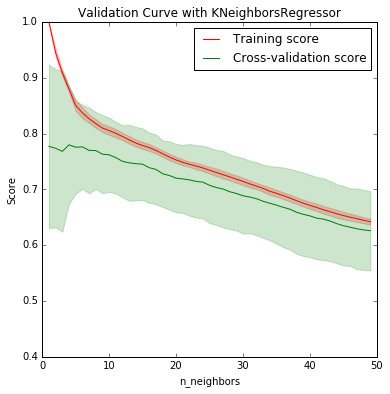

In [16]:
# For parametr alpha
#param_range = np.logspace(-10.0, 10.0)
#param_range = np.linspace(1,50,100)
param_range = np.arange(1,50) # generate integer numbers

train_scores, test_scores = validation_curve(
    KNeighborsRegressor(), X, Y, param_name="n_neighbors", param_range=param_range,
    cv=num_folds,  n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNeighborsRegressor")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

Less that 10 is the best of number of K

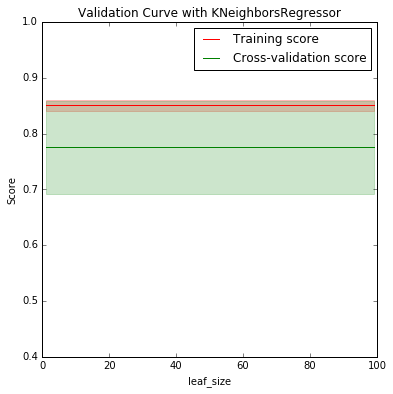

In [17]:
# For parametr alpha
#param_range = np.logspace(-10.0, 10.0)
#param_range = np.linspace(1,50,100)
param_range = np.arange(1,100) # generate integer numbers

train_scores, test_scores = validation_curve(
    KNeighborsRegressor(), X, Y, param_name="leaf_size", param_range=param_range,
    cv=num_folds,  n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNeighborsRegressor")
plt.xlabel("leaf_size")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

leaf_size does not effect so will keep the defulte one which is 30

## Grid search and/or Random search to determine best compination of parameters

In [ ]:
# Utility function to report optimal parameters
from operator import itemgetter
def report(grid_scores, n_top=5):
    params = None
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Parameters with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
              score.mean_validation_score, np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if params == None:
            params = score.parameters
    
    return params

# The most common value for the max number of features to look at in each split is sqrt(# of features)
sqrtfeat = np.sqrt(X.shape[1]) 
# Simple grid test (162 combinations)
grid_test1 = { "n_neighbors"      : [1,5,10],
                "algorithm"      : ["auto", "ball_tree", "kd_tree", "brute"]}

# Large randomized test using max_depth to control tree size (5000 possible combinations)
random_test1 = { "n_neighbors"      : np.arange(1,2),
                "algorithm"      : ["auto", "ball_tree", "kd_tree", "brute"]}


forest = KNeighborsRegressor()

print "Hyperparameter optimization using GridSearchCV..."
grid_search = GridSearchCV(forest, grid_test1, n_jobs=-1, cv=num_folds)
grid_search.fit(X, Y)
best_params_from_grid_search = report(grid_search.grid_scores_)
print '+++++++++++++++++++++++++++++++++++++++++++++++'
print "Hyperparameter optimization using RandomizedSearchCV"
grid_search = RandomizedSearchCV(forest, random_test1, n_jobs=-1, cv=num_folds, n_iter=1)
grid_search.fit(X, Y)
best_params_from_rand_search1 = report(grid_search.grid_scores_)

Hyperparameter optimization using GridSearchCV...


Best parameters Parameters: Parameters: Parameters: {'n_neighbors': 4, 'algorithm': 'kd_tree'}



## Learning Curve 

In essence, what we’re doing it training the exact same model with increasingly large fractions of our total training data, and plotting the error of the training and test sets at each step.

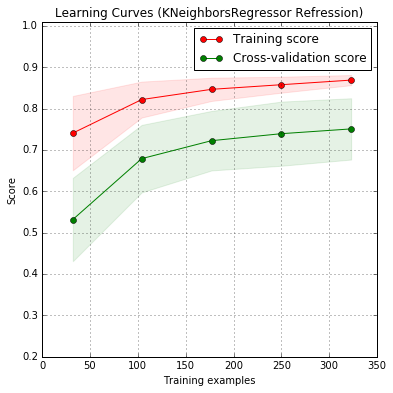

In [18]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors = 4, algorithm = 'kd_tree')
title = "Learning Curves (KNeighborsRegressor Refression)"
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)
plot_learning_curve(model, title, X, Y, ylim=(0.2, 1.01), cv=cv, n_jobs=-1)
plt.show()

In [19]:
# More data from learning curve to show the process of building the model
train_sizes, train_scores, valid_scores = learning_curve(
     model, X, Y, train_sizes=[50, 80, 110], cv=cv, n_jobs=4)

print 'train_sizes = ', train_sizes

print ' training scores'
print ' 50 training sizees'
print train_scores[0].mean(),'±',train_scores[0].std()
print ' 80 training sizees'
print train_scores[1].mean(),'±',train_scores[1].std()
print ' 110 training sizees'
print train_scores[2].mean(),'±',train_scores[2].std()

print '\n validation scores'
print ' 50 validation scores'
print valid_scores[0].mean(),'±',valid_scores[0].std()
print ' 80 validation scores'
print valid_scores[1].mean(),'±',valid_scores[1].std()
print ' 110 validation scores'
print valid_scores[2].mean(),'±',valid_scores[2].std()

train_sizes =  [ 50  80 110]
 training scores
 50 training sizees
0.775838608615 ± 0.0657418768526
 80 training sizees
0.805475455002 ± 0.0520943693002
 110 training sizees
0.825269471143 ± 0.0410990045311

 validation scores
 50 validation scores
0.60332713079 ± 0.0920475344502
 80 validation scores
0.655452828714 ± 0.0831808412531
 110 validation scores
0.687305675907 ± 0.0804660791947


## Cross validation

In [20]:
scoring = 'mean_squared_error'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print 'Scoring according to mean_squared_error'
print results
print '\n Mean      Standard deviation'
print("%.2f      %.2f" % (results.mean(), results.std()))
## Fit the model
model.fit(X,Y)


Scoring according to mean_squared_error
[-14.12878049  -6.94830793 -14.44443598 -25.74519817 -12.2221875
 -15.34967188 -28.0481875  -23.49503125 -29.88301562  -9.34292187]

 Mean      Standard deviation
-17.96      7.73


KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

## Coefficients Of Determination {Calculating R^2}

R^2, Close to one is better

In [21]:
predicted = cross_val_predict(model, X, Y, cv=kfold)
r_squared = r2_score(Y, predicted, multioutput='variance_weighted')
print 'R-squared = ',r_squared

R-squared =  0.789360922554


## Residual Plot

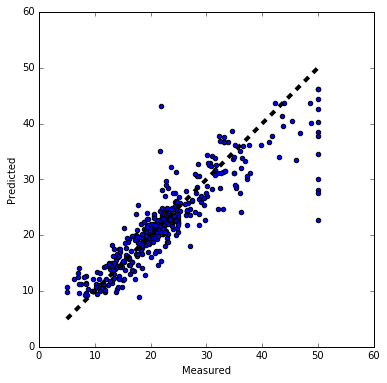

In [22]:
predicted = cross_val_predict(model, X, Y, cv=kfold)
fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [23]:
# Plotining using bokeh
#TOOLS = [BoxSelectTool(), HoverTool()]
#TOOLS = 'hover,box_zoom,box_select,crosshair,resize,reset,KNeighborsRegressor_select,pan,save,poly_select,tap,wheel_zoom,undo'
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
p = figure(plot_width=500, plot_height=500, tools=TOOLS)
p.scatter(Y, predicted,x="jjj", marker="o", color="#80B1D3", line_width=3)
p.title.align = "center"
p.xaxis.axis_label = "Measured"
p.xaxis.axis_label_text_color = "#aa6666"
#p.xaxis.axis_label_standoff = 30
p.xaxis.major_tick_line_color = "firebrick"
p.xaxis.major_tick_line_width = 3
p.xaxis.minor_tick_line_color = "orange"
p.yaxis.axis_label = "Predicted"
p.yaxis.axis_label_text_font_style = "italic"
p.yaxis.axis_label_text_color = "#aa6666"
p.background_fill_color = "beige"
p.background_fill_alpha = 0.5
#p.line([Y.min(), Y.max()], [Y.min(), Y.max()], line_dash="4 4", line_width=2, color='red')

# create a new plot with the toolbar below
# line_dash="4 4", line_width=2, color='red'
p.line([Y.min(), Y.max()], [Y.min(), Y.max()], line_dash="4 4", line_width=2, line_color="black")
show(p)

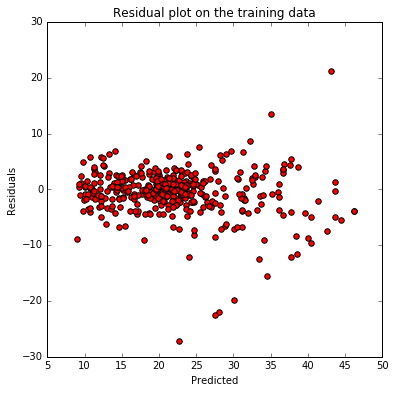

In [24]:
plt.scatter(predicted, (predicted - Y), c='r', s=30)
plt.title("Residual plot on the training data")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

In [25]:
# Plotining using bokeh
#TOOLS = 'hover,box_zoom,box_select,crosshair,resize,reset,KNeighborsRegressor_select,pan,save,poly_select,tap,wheel_zoom,undo'
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
p = figure(plot_width=500, plot_height=500, title="Residual plot on the training data", tools=TOOLS)
p.scatter(predicted, (predicted - Y),x="jjj", marker="o", color="#80B1D3", line_width=3)
p.title.align = "center"
p.xaxis.axis_label = "Predicted"
p.xaxis.axis_label_text_color = "#aa6666"
#p.xaxis.axis_label_standoff = 30
p.xaxis.major_tick_line_color = "firebrick"
p.xaxis.major_tick_line_width = 3
p.xaxis.minor_tick_line_color = "orange"
p.yaxis.axis_label = "Residuals"
p.yaxis.axis_label_text_font_style = "italic"
p.yaxis.axis_label_text_color = "#aa6666"
p.background_fill_color = "beige"
p.background_fill_alpha = 0.5
#p.line([2,38], [0, 0], line_dash="4 4", line_width=2, color='red')
show(p)

## Pipeline

The best to deliver the model by pipeline the operation then at deployment can be done in one model.

  I used two ways to check the pipeline so any one can be fine

In [26]:
# Use Pipeline
# ANOVA 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
anova_filter = SelectKBest(f_regression, k=13)
LR = KNeighborsRegressor(n_neighbors = 4, algorithm = 'kd_tree')
anova_LinReg = Pipeline([('scaler_Input',scaler), ('anova', anova_filter), ('LinReg', LR)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
anova_LinReg.set_params(anova__k=13).fit(new_data, Y)
prediction = anova_LinReg.predict(new_data)
print anova_LinReg.score(new_data, Y)                        
# getting the selected features chosen by anova_filter
results = cross_validation.cross_val_score(anova_LinReg, new_data, Y, cv=kfold, scoring=scoring)
print 'Scoring according to mean_squared_error'
print results
print '\n Mean      Standard deviation'
print("%.2f      %.2f" % (results.mean(), results.std()))
print anova_LinReg.named_steps['anova'].get_support()
r_squared = r2_score(Y, prediction, multioutput='variance_weighted')
print 'R-squared = ',r_squared

0.887507691833
Scoring according to mean_squared_error
[-16.76282012  -6.94830793 -14.67760671 -25.74519817 -11.96945313
 -15.27239063 -27.9436875  -23.24384375 -29.88301562  -8.89465625]

 Mean      Standard deviation
-18.13      7.67
[ True  True  True  True  True  True  True  True  True  True  True  True
  True]
R-squared =  0.887507691833


In [27]:
# Using make_pipeline
from sklearn.pipeline import make_pipeline

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=13)
anova_KNeighborsRegressor = make_pipeline(scaler, anova_filter, LR)
anova_KNeighborsRegressor.fit(new_data, Y)
prediction = anova_KNeighborsRegressor.predict(new_data)
r_squared = r2_score(Y, prediction, multioutput='variance_weighted')
print 'R-squared = ',r_squared

R-squared =  0.887507691833


### Save the Pipeline model for developement

In [28]:
# save the model scaler to the desk
from sklearn.externals import joblib
joblib.dump(anova_KNeighborsRegressor, 'anova_KNeighborsRegressor.pkl') 

['anova_KNeighborsRegressor.pkl',
 'anova_KNeighborsRegressor.pkl_01.npy',
 'anova_KNeighborsRegressor.pkl_02.npy',
 'anova_KNeighborsRegressor.pkl_03.npy',
 'anova_KNeighborsRegressor.pkl_04.npy',
 'anova_KNeighborsRegressor.pkl_05.npy',
 'anova_KNeighborsRegressor.pkl_06.npy',
 'anova_KNeighborsRegressor.pkl_07.npy',
 'anova_KNeighborsRegressor.pkl_08.npy',
 'anova_KNeighborsRegressor.pkl_09.npy',
 'anova_KNeighborsRegressor.pkl_10.npy',
 'anova_KNeighborsRegressor.pkl_11.npy',
 'anova_KNeighborsRegressor.pkl_12.npy',
 'anova_KNeighborsRegressor.pkl_13.npy']

In [29]:
# Test the model if it is work
anova_KNeighborsRegressorTest = joblib.load('anova_KNeighborsRegressor.pkl')
NewPred = anova_KNeighborsRegressorTest.predict(new_data)
print " =================================================================>>>>> done"
r_squared = r2_score(Y, NewPred, multioutput='variance_weighted')
print 'R-squared = ',r_squared

 =================================================================>>>>> done
R-squared =  0.887507691833


In [30]:
# test on single data point, randomly choose point number 55
print 'Point of training data before normalization\n',new_data[55]
print '\nThe read target of the data = ', Y[55]
NewPred = anova_KNeighborsRegressorTest.predict([new_data[55]])
print '\nThe Predicted target of the data = ', NewPred

Point of training data before normalization
[   1.23247    0.         8.14       0.         0.538      6.142     91.7
    3.9769     4.       307.        21.       396.9       18.72   ]

The read target of the data =  15.2

The Predicted target of the data =  [ 15.7]


## Conclusion 